# Whitened PSD

* **author**: steeve.laquitaine@epfl.ch

* **Execution duration:** : 10 mins for 10 min recordings

* **Method**: 
    * PSD for first 10 minutes of recording. We will analyse the first 10 minutes as PSD is stable across time (compared with 40 min).
    * `Horvath` (aligned with cortical column)
        * rat cortex S1
        * 128ch
        * 30.0kHz
        * Horvath in vivo probe 1:
            * duration: 3606.552 (~60 mins)
        * Horvath in vivo probe 2:
            * duration: 3688.668 secs (~61 mins)
        * Horvath in vivo probe 3:
            * duration: 3603.096 secs (~60 mins)  
        * "Spontaneous activity" (Only anesthetized condition)
    * `high-density (Horvath)` (aligned with cortical column)
        * run: 2023_10_18
        * rat cortex S1
        * 384ch 
        * 40.0kHz
        * 10 min
        * "Spontaneous activity" (Only anesthetized condition)
        * fitted gain and noise + fine tuned gain
        * Silico probe 1
            * duration: 1175.9988 secs (~28 min)
        * Silico probe 2   
            * duration: 1714.99825 secs (~19 min)
        * Silico probe 3: 
            * duration: 1763.9982 secs  (~29 min)
    * `Buccino`:
        * 10 min
    * Welch method
        * 1Hz resolution, Hann window
    * The quality of PSD estimation from FFT depends on a unique parameter, the number of signal samples, N. The largest the number of samples, 
    and the better the frequency resolution, $f_r$, of the PSD, given sampling frequency $f_s$

    $$f_r = f_s / N$$

    * We estimated all PSDs over the same number of recording samples, to allow for a fair comparison of PSDs which frequency resolution depends on the signal's sample size. Small sample size degrades the frequency resolution of the PSD compared to large sample size, potentially masking significant features.
    * To minimize computational cost, we show the PSDs estimated from the same sample sizes corresponding to about 5 min of recordings, which was the shortest period that best preserved the features observed in the PSD estimated from the entire recordings.
    * We also estimated the PSD for all experiments' first 20 minutes (the largest common duration) and the entire recordings (see Supplementary figure).

### Setup

1. Activate `spikeinterf..` venv

2. Compute power spectral data with: 

    ```bash
    # neuropixels (Marques & biophy. spontaneous)
    sbatch cluster/validation/psd/psd_welch_buttw_fitd_horv_10m.sbatch # 5 min
    sbatch cluster/validation/psd/psd_welch_buttw_fitd_npx_10m.sbatch # 16 min
    ```

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy
import multiprocessing
import torch

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
SFREQ_HV = 20000          # sampling frequency
SFREQ_HS = 20000        # sampling frequency
SFREQ_MV = 30000          # sampling frequency
SFREQ_MS = 40000        # sampling frequency
SFREQ_B = 32000

# SETUP DATASETS

# neuropixels *********************

# neuropixels (Marques-Smith)
cfg_nv, _ = get_config("vivo_marques", "c26").values() 
RAW_PATH_nv = cfg_nv["probe_wiring"]["output"]
PREP_PATH_nv = cfg_nv["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_NV = cfg_nv["validation"]["psd"]["raw"]
PRE_PSD_PATH_NV = cfg_nv["validation"]["psd"]["preprocessed"]

# neuropixels (biophy. spont.)
cfg_ns, param_conf_ns = get_config("silico_neuropixels", "concatenated").values()
RAW_PATH_ns = cfg_ns["probe_wiring"]["40m"]["output_noise_fitd_gain_fitd_adj10perc_less_int16"]
PREP_PATH_ns = cfg_ns["preprocessing"]["output"]["40m"]["trace_file_path_gain_fitd_adj10perc_less_noise_fitd_int16"]
RAW_PSD_PATH_NS = cfg_ns["validation"]["psd"]["raw"]
PRE_PSD_PATH_NS = cfg_ns["validation"]["psd"]["preprocessed"]

# neuropixels (evoked biophy.)
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
RAW_PATH_ne = cfg_ne["probe_wiring"]["output"]
PREP_PATH_ne = cfg_ne["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_NE = cfg_ne["validation"]["psd"]["raw"]
PRE_PSD_PATH_NE = cfg_ne["validation"]["psd"]["preprocessed"]

# neuropixels (synthetic, Buccino)
cfg_nb, param_conf_nb = get_config("buccino_2020", "2020").values()
RAW_PSD_PATH_NB = cfg_nb["validation"]["psd"]["raw"]
PRE_PSD_PATH_NB = cfg_nb["validation"]["psd"]["preprocessed"]

# custom *******************
# vivo (probe 1)
cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
RAW_PATH_hv1 =  cfg_hv1["probe_wiring"]["output"]
PREP_PATH_hv1 = cfg_hv1["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
RAW_PATH_hv2 =  cfg_hv2["probe_wiring"]["output"]
PREP_PATH_hv2 = cfg_hv2["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
RAW_PATH_hv3 =  cfg_hv3["probe_wiring"]["output"]
PREP_PATH_hv3 = cfg_hv3["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["preprocessed"]
# biophy. model
# (probe 1)
cfg_hs1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
RAW_PATH_hs1 = cfg_hs1["probe_wiring"]["output"]
PREP_PATH_hs1 = cfg_hs1["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hs2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
RAW_PATH_hs2 = cfg_hs2["probe_wiring"]["output"]
PREP_PATH_hs2 = cfg_hs2["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hs3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
RAW_PATH_hs3 = cfg_hs3["probe_wiring"]["output"]
PREP_PATH_hs3 = cfg_hs3["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["preprocessed"]


# # neuro 


# FIGURE SETTINGS
# sampling frequency
SFREQ_NV = 30000        
SFREQ_NS = 40000
SFREQ_NE = 20000
SFREQ_NB = 32000
SFREQ_HV = 20000        
SFREQ_HS = 20000


# FIGURE SETTINGS
FIG_SIZE = (1.05, 1.05)
# experiment colors
COLOR_NV = [0.4, 0.4, 0.4]
COLOR_NS = [0.9, 0.14, 0.15]
COLOR_HV = [0.75, 0.75, 0.75] # light
COLOR_HS = [0.9, 0.64, 0.65] # light
COLOR_NB = [0.22, 0.5, 0.72]
COLOR_NE = [1, 0.49, 0]

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

2024-06-27 09:18:44,909 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-27 09:18:44,992 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-27 09:18:44,993 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-27 09:18:45,083 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-27 09:18:45,085 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-27 09:18:45,136 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-27 09:18:45,137 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-27 09:18:45,173 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-27 09:18:45,174 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-27 09:18:45,207 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-27 09:18:45,208 - root - utils.py - get_config 

### Specs

In [2]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 72
available gpus: True


['              total        used        free      shared  buff/cache   available',
 'Mem:         772341       22269      749010          80        1061      748425',
 'Swap:             0           0           0']

### (1s)Load dataset

* select first 10 min for speed

In [3]:
# Load traces
# neuropixels
# raw
RawNV = si.load_extractor(RAW_PATH_nv)
RawNS = si.load_extractor(RAW_PATH_ns)
RawNE = si.load_extractor(RAW_PATH_ne)
# preprocessed
PrepNV = si.load_extractor(PREP_PATH_nv)
PrepNS = si.load_extractor(PREP_PATH_ns)
PrepNE = si.load_extractor(PREP_PATH_ne)

# horvath
# raw (probe 1)
RawHV1 = si.load_extractor(RAW_PATH_hv1)
RawHS1 = si.load_extractor(RAW_PATH_hs1)
# raw (probe 2)
RawHV2 = si.load_extractor(RAW_PATH_hv2)
RawHS2 = si.load_extractor(RAW_PATH_hs2)
# raw (probe 3)
RawHV3 = si.load_extractor(RAW_PATH_hv3)
RawHS3 = si.load_extractor(RAW_PATH_hs3)
# preprocessed (probe 1)
PrepHV1 = si.load_extractor(PREP_PATH_hv1)
PrepHS1 = si.load_extractor(PREP_PATH_hs1)
# preprocessed (probe 2)
PrepHV2 = si.load_extractor(PREP_PATH_hv2)
PrepHS2 = si.load_extractor(PREP_PATH_hs2)
# preprocessed (probe 3)
PrepHV3 = si.load_extractor(PREP_PATH_hv3)
PrepHS3 = si.load_extractor(PREP_PATH_hs3)


# 4 - get good sites (in cortex) **********************
# neuropixels
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
# silico
site_ly_ns = RawNS.get_property("layers")
site_ly_ns[site_ly_ns == "L2"] = "L2_3"
site_ly_ns[site_ly_ns == "L3"] = "L2_3"
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]
# evoked
site_ly_ne = RawNE.get_property("layers")
site_ly_ne[site_ly_ne == "L2"] = "L2_3"
site_ly_ne[site_ly_ne == "L3"] = "L2_3"
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]
# vivo
site_ly_nv = RawNV.get_property("layers")
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

# horvath
# silico
# probe 1 (select L1, L2/3)
site_ly_hs1 = RawHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]
# probe 2 (select L4 and L5)
site_ly_hs2 = RawHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hs3 = RawHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# vivo
# probe 1
site_ly_hv1 = RawHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]
# probe 2
site_ly_hv2 = RawHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
# probe 3
site_ly_hv3 = RawHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

# Load pre-computed PSDs
# neuropuxels
# raw
psd_raw_nv = np.load(RAW_PSD_PATH_NV, allow_pickle=True).item()
psd_raw_ns = np.load(RAW_PSD_PATH_NS, allow_pickle=True).item()
psd_raw_ne = np.load(RAW_PSD_PATH_NE, allow_pickle=True).item()
psd_raw_nb = np.load(RAW_PSD_PATH_NB, allow_pickle=True).item()
# preprocessed
psd_pre_nv = np.load(PRE_PSD_PATH_NV, allow_pickle=True).item()
psd_pre_ns = np.load(PRE_PSD_PATH_NS, allow_pickle=True).item()
psd_pre_ne = np.load(PRE_PSD_PATH_NE, allow_pickle=True).item()
psd_pre_nb = np.load(PRE_PSD_PATH_NB, allow_pickle=True).item()

# custom (Horvath)
psd_raw_hv1 = np.load(RAW_PSD_PATH_HV1, allow_pickle=True).item()
psd_raw_hv2 = np.load(RAW_PSD_PATH_HV2, allow_pickle=True).item()
psd_raw_hv3 = np.load(RAW_PSD_PATH_HV3, allow_pickle=True).item()
psd_raw_hs1 = np.load(RAW_PSD_PATH_HS1, allow_pickle=True).item()
psd_raw_hs2 = np.load(RAW_PSD_PATH_HS2, allow_pickle=True).item()
psd_raw_hs3 = np.load(RAW_PSD_PATH_HS3, allow_pickle=True).item()
# preprocessed
psd_pre_hv1 = np.load(PRE_PSD_PATH_HV1, allow_pickle=True).item()
psd_pre_hv2 = np.load(PRE_PSD_PATH_HV2, allow_pickle=True).item()
psd_pre_hv3 = np.load(PRE_PSD_PATH_HV3, allow_pickle=True).item()
psd_pre_hs1 = np.load(PRE_PSD_PATH_HS1, allow_pickle=True).item()
psd_pre_hs2 = np.load(PRE_PSD_PATH_HS2, allow_pickle=True).item()
psd_pre_hs3 = np.load(PRE_PSD_PATH_HS3, allow_pickle=True).item()

# unit-test power spectral density resolutions
assert psd_raw_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_nv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

assert psd_pre_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

#### (2m) Plot column

The PSD is averaged over sites by layer. We used the median of the mean due to the small number of sites per layer.

### (1s)Plot

compute plot

In [5]:
# # calculate psd plot stats
# (
#     psd_mean_raw_hv2,
#     psd_mean_raw_hv3,
#     psd_mean_raw_hs1,
#     psd_mean_raw_hs2,
#     psd_mean_raw_hs3,
#     psd_mean_raw_nv,
#     psd_mean_raw_ns,
#     psd_mean_raw_ne,
#     psd_mean_raw_nb,
#     psd_mean_pre_hv1,
#     psd_mean_pre_hv2,
#     psd_mean_pre_hv3,
#     psd_mean_pre_hs1,
#     psd_mean_pre_hs2,
#     psd_mean_pre_hs3,
#     psd_mean_pre_nv,
#     psd_mean_pre_ns,
#     psd_mean_pre_ne,
#     psd_mean_pre_nb,
#     ci_raw_hv2,
#     ci_raw_hv3,
#     ci_raw_hs1,
#     ci_raw_hs2,
#     ci_raw_hs3,
#     ci_raw_nv,
#     ci_raw_ns,
#     ci_raw_ne,
#     ci_raw_nb,
#     ci_pre_hv1,
#     ci_pre_hv2,
#     ci_pre_hv3,
#     ci_pre_hs1,
#     ci_pre_hs2,
#     ci_pre_hs3,
#     ci_pre_nv,
#     ci_pre_ns,
#     ci_pre_ne,
#     ci_pre_nb,
# ) = power.get_psd_plot_mean_and_ci(
#     psd_raw_hv1,
#     psd_raw_hv2,
#     psd_raw_hv3,
#     psd_raw_hs1,
#     psd_raw_hs2,
#     psd_raw_hs3,
#     psd_raw_nv,
#     psd_raw_ns,
#     psd_raw_ne,
#     psd_raw_nb,
#     psd_pre_hv1,
#     psd_pre_hv2,
#     psd_pre_hv3,
#     psd_pre_hs1,
#     psd_pre_hs2,
#     psd_pre_hs3,
#     psd_pre_nv,
#     psd_pre_ns,
#     psd_pre_ne,
#     psd_pre_nb,
# )

plot avg

    silico:
        first band: 0-70Hz -> better 0 - 90Hz
        2nd band: 70 - 2000 --> better 0 - 110Hz
        2nd band: 2500 - 200Nyquist

Normalizing psds, plotting three on the left y-scale and horvath vivo on a different y-scale was the only way to compare all psds on the same plot.

In [6]:
# plot params
pm = {
    "linestyle": "-",
    "linewidth": 0.5,
    "marker": ".",
    "markersize": 3.5,
    # "markeredgecolor": "w",
    "markeredgewidth": 0.1,
    "rasterized": True,
}
plt.rcParams["axes.spines.right"] = True

In [7]:
# # plot
# fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)
# # horvath vivo (on a different scale (right y-axis))
# ax2 = ax1.twinx()
# ax2, w_data_hv = power.plot_whitened(
#     ax2,
#     psd_raw_hv1,
#     (0, SFREQ_HV / 2),
#     "first_power",
#     True,
#     (0.3, 0.3, 0.3),
#     pm,
#     plot_fit=False,
# )
# # marques vivo
# ax1, w_data_mv = power.plot_whitened(
#     ax1,
#     psd_raw_nv,
#     (0, SFREQ_MV / 2),
#     "first_power",
#     True,
#     (0.75, 0.75, 0.75),
#     pm,
#     False,
# )
# # marques silico
# ax1, w_data_ms = power.plot_whitened(
#     ax1, psd_raw_ns, (0, 3000), "first_power", True, (1, 0.6, 0.6), pm, plot_fit=False
# )
# # horvath silico
# ax1, w_data_hs = power.plot_whitened(
#     ax1,
#     psd_raw_hs1,
#     (0, SFREQ_HS / 2),
#     "first_power",
#     True,
#     (1, 0, 0),
#     pm,
#     plot_fit=False,
# )


# # axes legend
# ax1.set_ylim([0, 0.005])
# ax1.set_yticks([0, 0.0025, 0.005], [0, 0.0025, 0.005])
# ax2.set_ylim([0, 0.4])
# ax2.set_yticks([0, 0.2, 0.4], [0, 0.2, 0.4])
# # esthetics
# ax1.set_xscale("log")
# # minor ticks
# locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
# locmin = matplotlib.ticker.LogLocator(
#     base=10.0,
#     subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
#     numticks=N_MINOR_TICKS,
# )
# ax1.tick_params(which="both")
# ax1.xaxis.set_major_locator(locmaj)
# ax1.xaxis.set_minor_locator(locmin)
# ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# # disconnect axes (R style)
# ax1.spines["bottom"].set_position(("axes", -0.05))
# ax1.yaxis.set_ticks_position("left")
# ax2.spines["bottom"].set_position(("axes", -0.05))
# ax2.yaxis.set_ticks_position("right")

# # plt.savefig("figures/2_realism/4_power/fig2g/whitened.svg", **savefig_cfg)

#### Compute layer 1 plot data
* probe 1 for horvath

In [8]:
# get L1 data
layer = "L1"
# horvath vivo (probe 1)
psd_raw_hv1_ = copy.copy(psd_raw_hv1)
psd_raw_hv1_["power"] = psd_raw_hv1["power"][site_ly_hv1[sites_hv1] == layer, :]
# biophy
psd_raw_hs1_ = copy.copy(psd_raw_hs1)
psd_raw_hs1_["power"] = psd_raw_hs1["power"][site_ly_hs1[sites_hs1] == layer, :]

# neuropixels
# vivo
psd_raw_nv_ = copy.copy(psd_raw_nv)
psd_raw_nv_["power"] = psd_raw_nv["power"][site_ly_nv[sites_nv] == layer, :]
# biophy spont
psd_raw_ns_ = copy.copy(psd_raw_ns)
psd_raw_ns_["power"] = psd_raw_ns["power"][site_ly_ns[sites_ns] == layer, :]
# biophy evoked
psd_raw_ne_ = copy.copy(psd_raw_ne)
psd_raw_ne_["power"] = psd_raw_ne["power"][site_ly_ne[sites_ne] == layer, :]

##### Plot PSDs per site

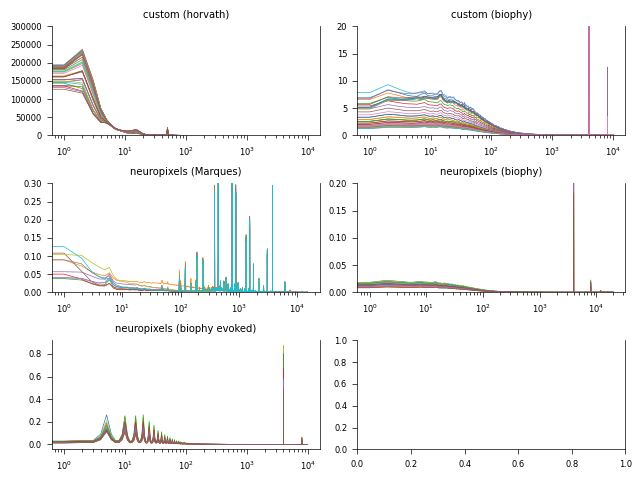

In [9]:
fig, ax = plt.subplots(3, 2)

# vivo
ax[0, 0].plot(psd_raw_hv1_["power"].T)
ax[0, 0].set_xscale("log")
ax[0, 0].set_ylim([0, 300000])
ax[0, 0].set_title("custom (horvath)")

# biophy
ax[0, 1].plot(psd_raw_hs1_["power"].T)
ax[0, 1].set_xscale("log")
ax[0, 1].set_ylim([0, 20])
ax[0, 1].set_title("custom (biophy)")

# neuropixels
# vivo
ax[1, 0].plot(psd_raw_nv_["power"].T)
ax[1, 0].set_xscale("log")
ax[1, 0].set_ylim([0, 0.3])
ax[1, 0].set_title("neuropixels (Marques)")

# biophy
ax[1, 1].plot(psd_raw_ns_["power"].T)
ax[1, 1].set_xscale("log")
ax[1, 1].set_ylim([0, 0.2])
ax[1, 1].set_title("neuropixels (biophy)")

# biophy evoked
ax[2, 0].plot(psd_raw_ne_["power"].T)
ax[2, 0].set_xscale("log")
# ax[2, 0].set_ylim([0, 0.2])
ax[2, 0].set_title("neuropixels (biophy evoked)")

fig.tight_layout()

### Plot average PSD

mean alpha: -0.6259124780011038
std alpha: 0.15287083045757704
n= 10
mean alpha: -0.68161677387719
std alpha: 0.0647518571679118
n= 16
mean alpha: -1.4610318614689697
std alpha: 0.09153646016767648
n= 36
mean alpha: -0.6745174366909187
std alpha: 0.1622482008367633
n= 37


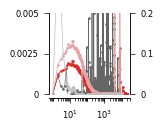

In [10]:
# (1s) plot
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# neuropixels *****************
# Marques-Smith
ax1, w_data_nv_l1 = power.plot_whitened(
    ax1,
    psd_raw_nv_,
    (0, 3000),
    "first_power",
    True,
    COLOR_NV,
    pm,
    False,
)
# biophy. spont.
ax1, w_data_ns_l1 = power.plot_whitened(
    ax1,
    psd_raw_ns_,
    (0, 3000),
    "first_power",
    True,
    COLOR_NS,
    pm,
    plot_fit=False,
)

# horvath *****************
# vivo (on a different scale (right y-axis))
ax2 = ax1.twinx()
ax2, w_data_hv1_l1 = power.plot_whitened(
    ax2,
    psd_raw_hv1_,
    (0, 3000),
    "first_power",
    True,
    COLOR_HV,
    pm,
    plot_fit=False,
)
# biophy. spont
ax1, w_data_hs1_l1 = power.plot_whitened(
    ax1,
    psd_raw_hs1_,
    (0, 3000),
    "first_power",
    True,
    COLOR_HS,
    pm,
    plot_fit=False,
)

# axes legend
ax1.set_ylim([0, 0.005])
ax1.set_yticks([0, 0.0025, 0.005], [0, 0.0025, 0.005])
ax2.set_ylim([0, 0.2])
ax2.set_yticks([0, 0.1, 0.2], [0, 0.1, 0.2])
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.yaxis.set_ticks_position("right")

# plt.savefig(
#     "figures/0_validation/4_power/fig2p/fig2p_L1_raw_whitened.svg", **savefig_cfg
# )

mean alpha: -0.6826850828955521
std alpha: 0.06050970108175553
n= 16


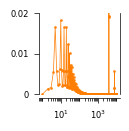

In [11]:
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# biophy.evoked
ax1, w_data_ne_l1 = power.plot_whitened(
    ax1,
    psd_raw_ne_,
    (0, 3000),
    "first_power",
    True,
    COLOR_NE,
    pm,
    plot_fit=False,
)

# axes legend
ax1.set_ylim([0, 0.02])
ax1.set_yticks([0, 0.01, 0.02], [0, 0.01, 0.02])
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)

ax1.spines["right"].set_visible("False")
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")

# plt.savefig(
#     "figures/0_validation/4_power/fig2p/fig2p_L1_raw_evoked_whitened.svg", **savefig_cfg
# )

#### plot layer 2/3

In [12]:
# get L2/3 data
layer = "L2_3"

# horvath vivo (probe 1)
psd_raw_hv1_ = copy.copy(psd_raw_hv1)
psd_raw_hv1_["power"] = psd_raw_hv1["power"][site_ly_hv1[sites_hv1] == layer, :]
# biophy
psd_raw_hs1_ = copy.copy(psd_raw_hs1)
psd_raw_hs1_["power"] = psd_raw_hs1["power"][site_ly_hs1[sites_hs1] == layer, :]

# neuropixels
# vivo
psd_raw_nv_ = copy.copy(psd_raw_nv)
psd_raw_nv_["power"] = psd_raw_nv["power"][site_ly_nv[sites_nv] == layer, :]
# biophy spont
psd_raw_ns_ = copy.copy(psd_raw_ns)
psd_raw_ns_["power"] = psd_raw_ns["power"][site_ly_ns[sites_ns] == layer, :]
# biophy evoked
psd_raw_ne_ = copy.copy(psd_raw_ne)
psd_raw_ne_["power"] = psd_raw_ne["power"][site_ly_ne[sites_ne] == layer, :]

##### Plot PSDs per site

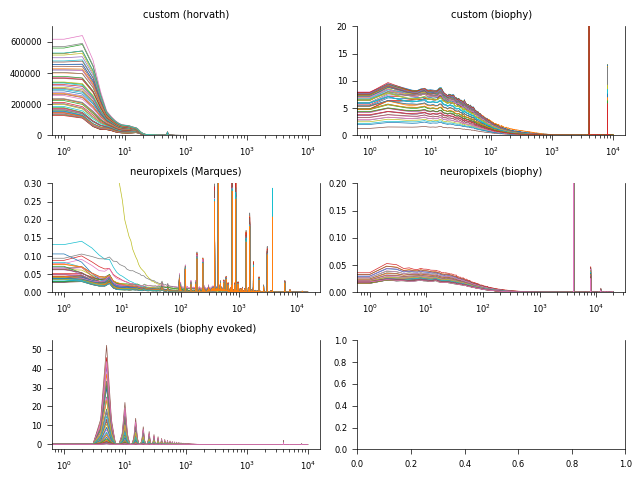

In [13]:
fig, ax = plt.subplots(3, 2)

# vivo
ax[0, 0].plot(psd_raw_hv1_["power"].T)
ax[0, 0].set_xscale("log")
ax[0, 0].set_ylim([0, 700000])
ax[0, 0].set_title("custom (horvath)")

# biophy
ax[0, 1].plot(psd_raw_hs1_["power"].T)
ax[0, 1].set_xscale("log")
ax[0, 1].set_ylim([0, 20])
ax[0, 1].set_title("custom (biophy)")

# neuropixels
# vivo
ax[1, 0].plot(psd_raw_nv_["power"].T)
ax[1, 0].set_xscale("log")
ax[1, 0].set_ylim([0, 0.3])
ax[1, 0].set_title("neuropixels (Marques)")

# biophy
ax[1, 1].plot(psd_raw_ns_["power"].T)
ax[1, 1].set_xscale("log")
ax[1, 1].set_ylim([0, 0.2])
ax[1, 1].set_title("neuropixels (biophy)")

# biophy evoked
ax[2, 0].plot(psd_raw_ne_["power"].T)
ax[2, 0].set_xscale("log")
# ax[2, 0].set_ylim([0, 0.2])
ax[2, 0].set_title("neuropixels (biophy evoked)")

fig.tight_layout()

##### Plot average PSDs

mean alpha: -0.5156507250432785
std alpha: 0.14575934704967877
n= 42
mean alpha: -0.8113001651611698
std alpha: 0.07305198460987897
n= 47
mean alpha: -1.8056015163209476
std alpha: 0.0521509988580852
n= 60
mean alpha: -0.782683092304659
std alpha: 0.1200902195673419
n= 64


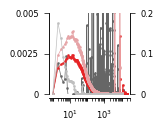

In [14]:
# (1s) plot
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# neuropixels *****************
# Marques-Smith
ax1, w_data_nv_l1 = power.plot_whitened(
    ax1,
    psd_raw_nv_,
    (0, 3000),
    "first_power",
    True,
    COLOR_NV,
    pm,
    False,
)
# biophy. spont.
ax1, w_data_ns_l1 = power.plot_whitened(
    ax1,
    psd_raw_ns_,
    (0, 3000),
    "first_power",
    True,
    COLOR_NS,
    pm,
    plot_fit=False,
)


# horvath *****************
# vivo (on a different scale (right y-axis))
ax2 = ax1.twinx()
ax2, w_data_hv1_l1 = power.plot_whitened(
    ax2,
    psd_raw_hv1_,
    (0, 3000),
    "first_power",
    True,
    COLOR_HV,
    pm,
    plot_fit=False,
)
# biophy. spont
ax1, w_data_hs1_l1 = power.plot_whitened(
    ax1,
    psd_raw_hs1_,
    (0, 3000),
    "first_power",
    True,
    COLOR_HS,
    pm,
    plot_fit=False,
)

# axes legend
ax1.set_ylim([0, 0.005])
ax1.set_yticks([0, 0.0025, 0.005], [0, 0.0025, 0.005])
ax2.set_ylim([0, 0.2])
ax2.set_yticks([0, 0.1, 0.2], [0, 0.1, 0.2])
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.yaxis.set_ticks_position("right")

# plt.savefig(
#     "figures/0_validation/4_power/fig2p/fig2p_raw_whitened_L23.svg", **savefig_cfg
# )

mean alpha: -0.9208439755206594
std alpha: 0.17384715992949648
n= 47


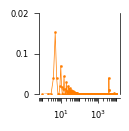

In [ ]:
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# biophy.evoked
ax1, w_data_ne_l1 = power.plot_whitened(
    ax1,
    psd_raw_ne_,
    (0, 3000),
    "first_power",
    True,
    COLOR_NE,
    pm,
    plot_fit=False,
)

# axes legend
ax1.set_ylim([0, 0.2])
ax1.set_yticks([0, 0.1, 0.2], [0, 0.1, 0.02])
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)


ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")

plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2p_raw_evoked_whitened_L23.svg",
    **savefig_cfg
)

#### plot layer 4

In [ ]:
# get L2/3 data
layer = "L4"
psd_raw_hv2 = copy.copy(psd_raw_hv)
psd_raw_hv2["power"] = psd_raw_hv2["power"][site_layers_hv == layer, :]
psd_raw_mv2 = copy.copy(psd_raw_mv)
psd_raw_mv2["power"] = psd_raw_mv2["power"][site_layers_mv == layer, :]
psd_raw_ms2 = copy.copy(psd_raw_ms)
psd_raw_ms2["power"] = psd_raw_ms2["power"][site_layers_ms == layer, :]
psd_raw_hs2 = copy.copy(psd_raw_hs)
psd_raw_hs2["power"] = psd_raw_hs2["power"][site_layers_hs == layer, :]

mean alpha: -1.6372002369343175
std alpha: 0.056419714184202094
n= 20
mean alpha: -0.5759256977509644
std alpha: 0.062132371669562474
n= 34
mean alpha: -1.1042105951833348
std alpha: 0.05517879714660059
n= 19
mean alpha: -0.5391314160898916
std alpha: 0.17859868648734642
n= 32


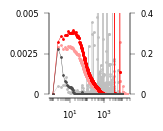

In [ ]:
# plot
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# horvath vivo (on a different scale (right y-axis))
ax2 = ax1.twinx()
ax2, w_data_hv_l23 = power.plot_whitened(
    ax2,
    psd_raw_hv2,
    (0, SFREQ_HV / 2),
    "first_power",
    True,
    (0.3, 0.3, 0.3),
    pm,
    plot_fit=False,
)
# marques vivo
ax1, w_data_l23 = power.plot_whitened(
    ax1,
    psd_raw_mv2,
    (0, SFREQ_MV / 2),
    "first_power",
    True,
    (0.75, 0.75, 0.75),
    pm,
    False,
)
# marques silico
ax1, w_data_l23 = power.plot_whitened(
    ax1, psd_raw_ms2, (0, 3000), "first_power", True, (1, 0.6, 0.6), pm, plot_fit=False
)
# horvath silico
ax1, w_data_l23 = power.plot_whitened(
    ax1,
    psd_raw_hs2,
    (0, SFREQ_HS / 2),
    "first_power",
    True,
    (1, 0, 0),
    pm,
    plot_fit=False,
)

# axes legend
ax1.set_ylim([0, 0.005])
ax1.set_yticks([0, 0.0025, 0.005], [0, 0.0025, 0.005])
ax2.set_ylim([0, 0.4])
ax2.set_yticks([0, 0.2, 0.4], [0, 0.2, 0.4])
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.yaxis.set_ticks_position("right")

plt.savefig("figures/2_realism/4_power/fig2g/whitened_l4.svg", **savefig_cfg)

#### plot layer 5

In [ ]:
layer = "L5"
psd_raw_hv2 = copy.copy(psd_raw_hv)
psd_raw_hv2["power"] = psd_raw_hv2["power"][site_layers_hv == layer, :]
psd_raw_mv2 = copy.copy(psd_raw_mv)
psd_raw_mv2["power"] = psd_raw_mv2["power"][site_layers_mv == layer, :]
psd_raw_ms2 = copy.copy(psd_raw_ms)
psd_raw_ms2["power"] = psd_raw_ms2["power"][site_layers_ms == layer, :]
psd_raw_hs2 = copy.copy(psd_raw_hs)
psd_raw_hs2["power"] = psd_raw_hs2["power"][site_layers_hs == layer, :]

mean alpha: -1.7166507879368011
std alpha: 0.14397701813437566
n= 88
mean alpha: -0.7848512404482271
std alpha: 0.11476243262791487
n= 42
mean alpha: -1.2396219866798182
std alpha: 0.05259682480548953
n= 52
mean alpha: -0.5738159659689115
std alpha: 0.11244397886082681
n= 88


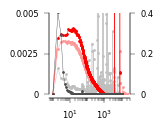

In [ ]:
# plot
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# horvath vivo (on a different scale (right y-axis))
ax2 = ax1.twinx()
ax2, w_data_hv_l23 = power.plot_whitened(
    ax2,
    psd_raw_hv2,
    (0, SFREQ_HV / 2),
    "first_power",
    True,
    (0.3, 0.3, 0.3),
    pm,
    plot_fit=False,
)
# marques vivo
ax1, w_data_l23 = power.plot_whitened(
    ax1,
    psd_raw_mv2,
    (0, SFREQ_MV / 2),
    "first_power",
    True,
    (0.75, 0.75, 0.75),
    pm,
    False,
)
# marques silico
ax1, w_data_l23 = power.plot_whitened(
    ax1, psd_raw_ms2, (0, 3000), "first_power", True, (1, 0.6, 0.6), pm, plot_fit=False
)
# horvath silico
ax1, w_data_l23 = power.plot_whitened(
    ax1,
    psd_raw_hs2,
    (0, SFREQ_HS / 2),
    "first_power",
    True,
    (1, 0, 0),
    pm,
    plot_fit=False,
)

# axes legend
ax1.set_ylim([0, 0.005])
ax1.set_yticks([0, 0.0025, 0.005], [0, 0.0025, 0.005])
ax2.set_ylim([0, 0.4])
ax2.set_yticks([0, 0.2, 0.4], [0, 0.2, 0.4])
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.yaxis.set_ticks_position("right")

plt.savefig("figures/2_realism/4_power/fig2g/whitened_l5.svg", **savefig_cfg)

#### plot layer 6 (None on probe 2)

# references

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
